In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import lenspyx
from lenspyx.lensing import get_geom

import healpy as hp

import shtns
import pysht

In [ ]:
# tlib.synthesis(alm, lmax=lmax, mmax=lmax, nthreads=1)
# pysht.set_backend('GPU')
# pysht.synthesis()


# Config

In [4]:
lmax, mmax = (4096, 4096)
lmaxs = [2**x for x in np.arange(4, 14, 2)]
lmaxs

[16, 64, 256, 1024, 4096]

# SHTns

In [3]:
# shtns.__dict__
# sh = shtns.sht(2, 2)
# sh_funcs = [method_name for method_name in dir(sh) if (callable(getattr(sh, method_name)) and not method_name.startswith("__"))]

# import inspect
# print(sh.__doc__)
# for func in sh_funcs:
#     print("{}{}:".format(func, inspect.signature(getattr(sh, func))))
#     print("\t'''\n{}".format(getattr(sh, func).__doc__).replace("\n", "\n\t"), end="\n\t'''\n\n")

In [5]:
"""
This cell initializes CPU and GPU and their grids
"""
sh_cpus = []
sh_gpus = []

for lmax in lmaxs:
    print(lmax)
    sh_cpus.append(shtns.sht(int(lmax), int(lmax)))
    sh_gpus.append(shtns.sht(int(lmax), int(lmax)))


[sh_gpu.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS) for sh_gpu in sh_gpus]
print('gpu grids set')

[sh_cpu.set_grid(flags=shtns.SHT_THETA_CONTIGUOUS) for sh_cpu in sh_cpus]
print('cpu grids set')

salms = [sh_gpu.spec_array() for sh_gpu in sh_gpus]
smaps = [sh_gpu.spat_array() for sh_gpu in sh_gpus]

16
64
256
1024
4096
gpu grids set
cpu grids set


In [7]:
"""
For various lmax, run alm2map() timing on CPU/GPU with SHTns
"""

stime_cpus = np.zeros_like(sh_cpus)
for sh_cpui, sh_cpu in enumerate(sh_cpus):
    stime_cpus[sh_cpui] = %timeit -o sh_cpu.synth(salms[sh_cpui])
stime_gpus = np.zeros_like(sh_gpus)
for sh_gpui, sh_gpu in enumerate(sh_gpus):
    stime_gpus[sh_gpui] = %timeit -o sh_gpu.synth(salms[sh_gpui])

# 5.7 µs ± 18.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
# 42.2 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 1.18 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
# 56.9 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 2.93 s ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 31.3 µs ± 992 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 66.3 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 509 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
# 7.43 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 144 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

6.96 µs ± 290 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
49.2 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.42 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
68.5 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.55 s ± 45.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.8 µs ± 437 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
77.8 µs ± 290 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
646 µs ± 1.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
9.29 ms ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
303 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Healpy

In [6]:
"""
For various lmax, run alm2map() timing on CPU with healpy 
"""
! export OMPU_NUM_THREADS=16
h_cpus = []
hmaps = []
h_alms = []
for lmax in lmaxs:
    h_alms.append(np.array([complex(a,b) for a, b in zip(np.random.random(size=hp.Alm.getsize(lmax)), np.random.random(size=hp.Alm.getsize(lmax)))]))

htime_cpus = [None for _ in lmaxs]
for h_almi, h_alm in enumerate(h_alms):
    htime_cpus[h_almi] = %timeit -o hp.alm2map(h_alm, nside=int((lmaxs[h_almi]+1)/2))

# 50.7 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 432 µs ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
# 9.85 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 359 ms ± 473 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 17.1 s ± 40.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

60 µs ± 503 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
516 µs ± 4.07 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
11.2 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
402 ms ± 8.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.4 s ± 513 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
! export OMPU_NUM_THREADS=16
! echo "$OMPU_NUM_THREADS"

# Lenspyx

In [14]:
"""
For various lmax, run alm2map() timing on CPU with healpy.
This cell generates alms
"""
pysht.set_backend('CPU')
# pysht.get_backend()

l_cpus = []
lmaps = []
lalms = []
for lmax in lmaxs:
    geominfo = ('gl',{'lmax': lmax})
    l_cpus.append(get_geom(geominfo))
    lmaps.append(np.random.random(size=l_cpus[-1].npix()))
    buffer = l_cpus[-1].map2alm(lmaps[-1], lmax=lmax, mmax=lmax, nthreads=4)
    lalms.append(np.array([complex(a,b) for a, b in zip(np.random.random(size=buffer.shape[0]), np.random.random(size=buffer.shape[0]))]))

In [15]:
"""
For various lmax, run alm2map() timing on CPU with lenspyx 
"""
ltime_cpus = np.zeros_like(l_cpus)
for l_cpui, l_cpu in enumerate(l_cpus):
    ltime_cpus[l_cpui] = %timeit -o l_cpu.alm2map(lalms[l_cpui], lmax=lmaxs[l_cpui], mmax=lmaxs[l_cpui], nthreads=1)


# 22.7 µs ± 103 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 174 µs ± 4.62 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 4.33 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 172 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 8.75 s ± 50 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

35.4 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
218 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
5.41 ms ± 265 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
204 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.7 s ± 296 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[]

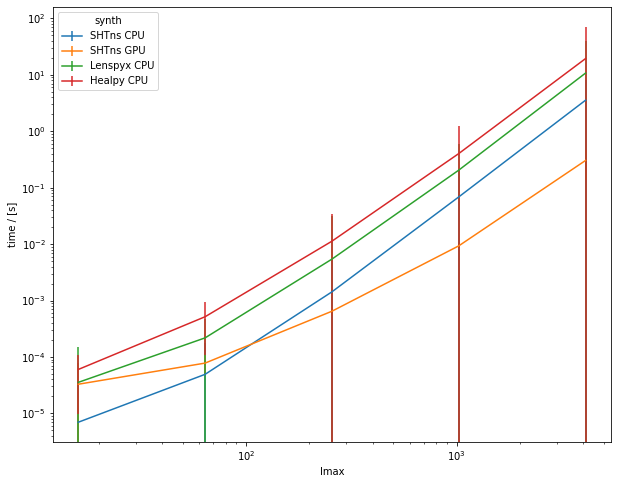

In [16]:
plt.figure(figsize=(10,8))
plt.errorbar(lmaxs, [stime.average for stime in stime_cpus], yerr=100*np.array([stime.stdev for stime in stime_cpus]), label='SHTns CPU')
plt.errorbar(lmaxs, [stime.average for stime in stime_gpus], yerr=100*np.array([stime.stdev for stime in stime_gpus]), label='SHTns GPU')
plt.errorbar(lmaxs, [ltime.average for ltime in ltime_cpus], yerr=100*np.array([ltime.stdev for ltime in ltime_cpus]), label='Lenspyx CPU')
plt.errorbar(lmaxs, [htime.average for htime in htime_cpus], yerr=100*np.array([htime.stdev for htime in htime_cpus]), label='Healpy CPU')
plt.legend(title='synth')

plt.xlabel('lmax')
plt.ylabel('time / [s]')
plt.loglog()